In [1]:
%load_ext autoreload
%autoreload 2

# Import modules and setup paths

In [2]:
import torch
import torchvision
assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 2.0.0
torchvision version: 0.15.0


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary



In [4]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular/going_modular/* .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/nfs/team205/sm58/analysis/ccc/env_trial3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# from tqdm.auto import tqdm
# for i in tqdm(range(10000)):
#     x =1+1

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
import os 
os.getcwd( )

'/nfs/team205/sm58/analysis/ViT_mrdbourke/scripts'

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# Preprocess the data
by resizing to 224 as explained in the ViT paper and using batch of 32 (inViT they did batch of 4096)

In [10]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [11]:
# Set the batch size
BATCH_SIZE = 2 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0372130730>,
 ['pizza', 'steak', 'sushi'])

# Visualize an image and label, and check dimensions

In [15]:
# I was getting an unexpected error that did allow me to iter over dataloader
# iter(train_dataloader)

torch.Size([3, 224, 224]) tensor(0)


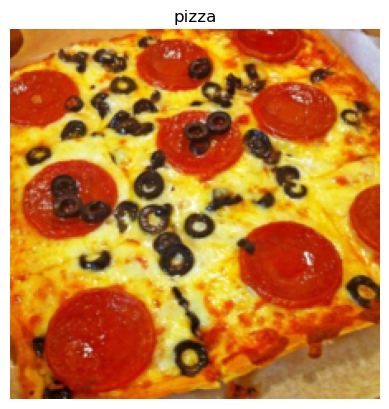

In [13]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# Create Patch Embedding Layer

In [16]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [17]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Visualize the patches

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


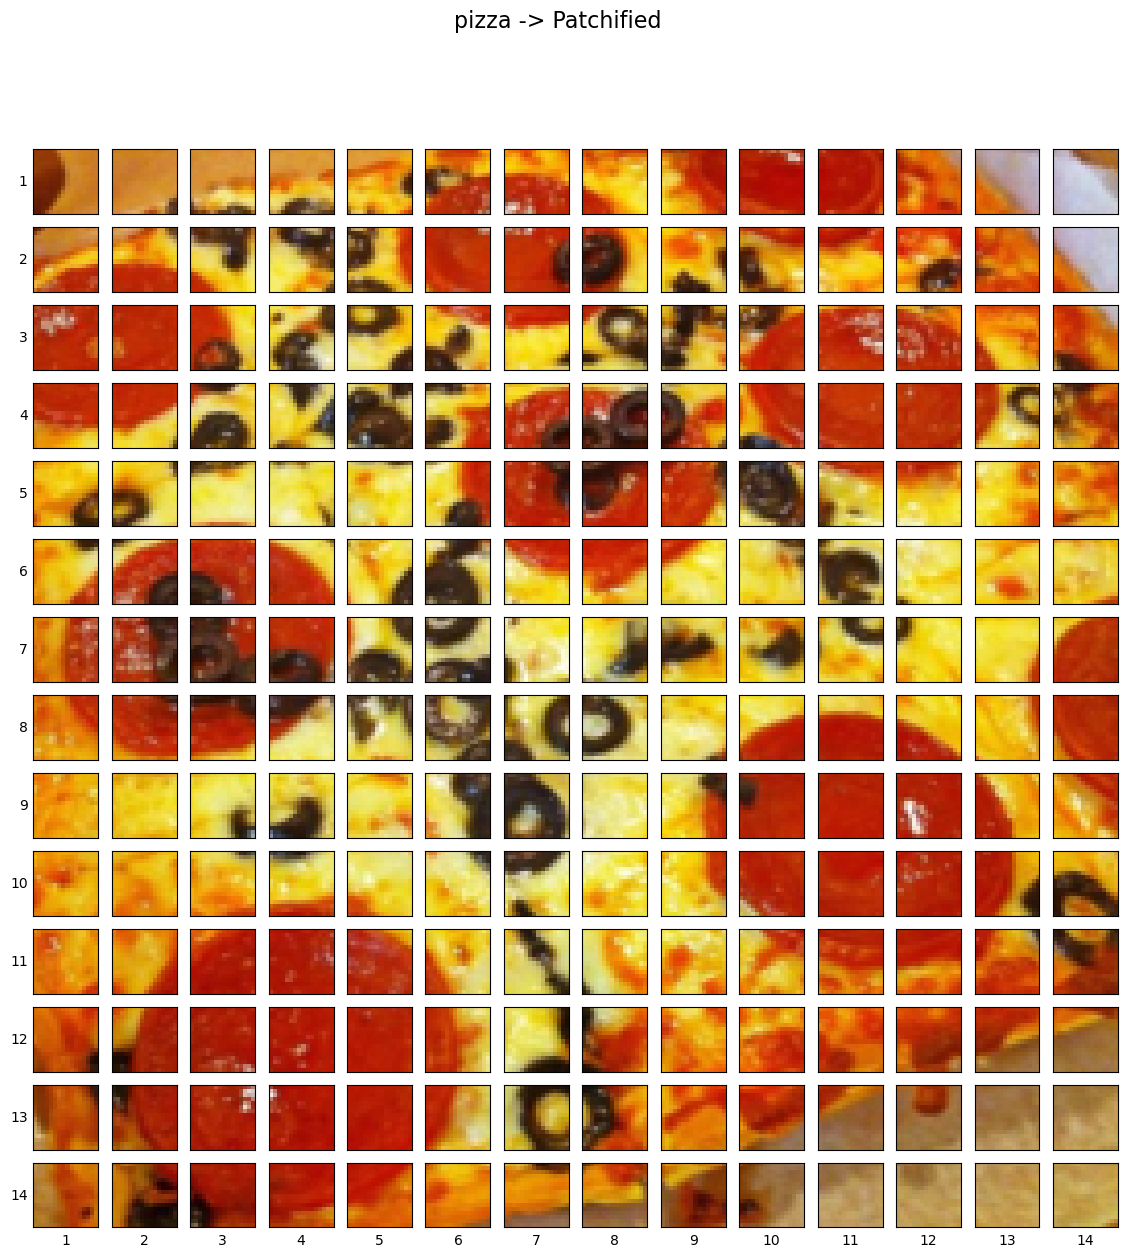

In [18]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [21]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

In [22]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [525, 529, 290, 646, 447]


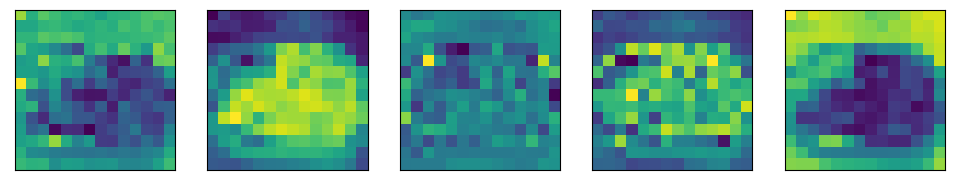

In [27]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [28]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.3343, -0.1710, -0.2719, -0.2087, -0.1875, -0.1630, -0.1615,
           -0.0746, -0.1155, -0.1372, -0.1557, -0.1957, -0.2306, -0.2134],
          [-0.1381, -0.1546, -0.1448, -0.2031, -0.1958, -0.1854, -0.1737,
           -0.1858, -0.1750, -0.1922, -0.1937, -0.2334, -0.2049, -0.2181],
          [-0.1664, -0.2060, -0.2319, -0.2167, -0.2097, -0.1968, -0.1709,
           -0.1582, -0.1555, -0.1484, -0.1998, -0.2238, -0.1921, -0.2141],
          [-0.2027, -0.1319, -0.1686, -0.2150, -0.2198, -0.2691, -0.1095,
           -0.2325, -0.3390, -0.3388, -0.1937, -0.2431, -0.3214, -0.2092],
          [-0.1445, -0.3007,  0.0855, -0.1727, -0.2605, -0.2074,  0.1812,
            0.0885,  0.0061, -0.0239, -0.1871, -0.1041,  0.1092, -0.4770],
          [-0.2136, -0.0654, -0.0833, -0.1475, -0.0879, -0.0718,  0.1752,
            0.0093, -0.0752,  0.0976, -0.0302,  0.0594, -0.2003,  0.1622],
          [-0.0755, -0.1130, -0.0715, -0.1792,  0.0743, -0.2435, -0.0124,
           -0.1364,  0.0455, -0.

In [29]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [30]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


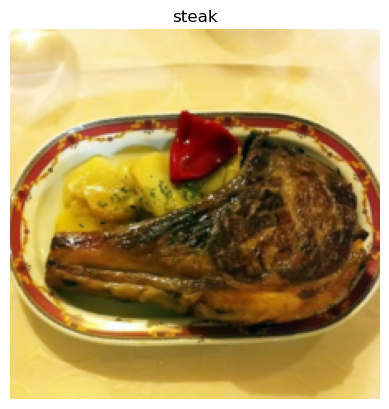

In [31]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [32]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


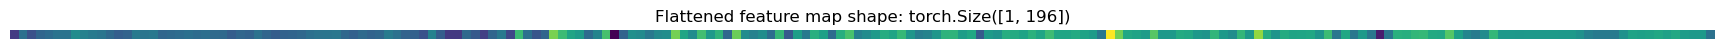

In [34]:
# Get a single flattened feature map and visualize it
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [35]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.3343, -0.1710, -0.2719, -0.2087, -0.1875, -0.1630, -0.1615, -0.0746,
          -0.1155, -0.1372, -0.1557, -0.1957, -0.2306, -0.2134, -0.1381, -0.1546,
          -0.1448, -0.2031, -0.1958, -0.1854, -0.1737, -0.1858, -0.1750, -0.1922,
          -0.1937, -0.2334, -0.2049, -0.2181, -0.1664, -0.2060, -0.2319, -0.2167,
          -0.2097, -0.1968, -0.1709, -0.1582, -0.1555, -0.1484, -0.1998, -0.2238,
          -0.1921, -0.2141, -0.2027, -0.1319, -0.1686, -0.2150, -0.2198, -0.2691,
          -0.1095, -0.2325, -0.3390, -0.3388, -0.1937, -0.2431, -0.3214, -0.2092,
          -0.1445, -0.3007,  0.0855, -0.1727, -0.2605, -0.2074,  0.1812,  0.0885,
           0.0061, -0.0239, -0.1871, -0.1041,  0.1092, -0.4770, -0.2136, -0.0654,
          -0.0833, -0.1475, -0.0879, -0.0718,  0.1752,  0.0093, -0.0752,  0.0976,
          -0.0302,  0.0594, -0.2003,  0.1622, -0.0755, -0.1130, -0.0715, -0.1792,
           0.0743, -0.2435, -0.0124, -0.1364,  0.0455, -0.0074, -0.1868,  0.0397,
           0.112

# ViT patch embedding layer into a PyTorch module

In [36]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [37]:
# Let's try it on a single embedding
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [39]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/nfs/team205/sm58/analysis/ccc/env_trial3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/nfs/team205/sm58/analysis/ccc/env_trial3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17